In [1]:
import subprocess
import os
import json
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style()

path_base = 'D:/Workspace/BSU-Parallel-Computing/Lab3'

In [2]:
def call(n, threads, save=True):
    path = os.path.join(path_base, 'Release/Lab3.exe')
    with open(os.path.join(path_base, 'Release/Lab3.pg'), 'w') as f:
        f.write(f'local {threads-1}')
    s = 1 if save else 0
    return subprocess.call([path, str(n), str(s)])

def test(n_range, t_range, verbose=False):
    vals = np.zeros((len(n_range),len(t_range),4))
    for j, t in enumerate(t_range):
        for i, n in enumerate(n_range):
            if verbose: 
                print(f"n = {n}; threads = {t}")
            to_validate = n<1000
            while call(n, t, save=to_validate):
                pass
            with open('time.json') as json_file:
                data = json.load(json_file)
            vals[i,j,0] = data['total']
            vals[i,j,1] = data['backward']
            vals[i,j,2] = np.mean([
                data[f'computation_{p}']
                for p in range(t)
            ])
            vals[i,j,3] = np.mean([
                data[f'communication_{p}']
                for p in range(t)
            ])
            if to_validate and not validate():
                print('Error!')
                return
    return vals

def validate():
    fpath = os.path.join(path_base,'A.txt')
    A = np.loadtxt(fpath, dtype=int, skiprows=1)
    fpath = os.path.join(path_base,'x.txt')
    x = np.loadtxt(fpath, dtype=float, skiprows=1)
    return np.all((np.linalg.solve(A[:,:-1], A[:,-1]) - x) < 1e-6)

In [3]:
n_range = [500, 1000, 1500, 2000]
t_range = [1, 2, 3, 4]

In [ ]:
vals = test(n_range, t_range, verbose=True)

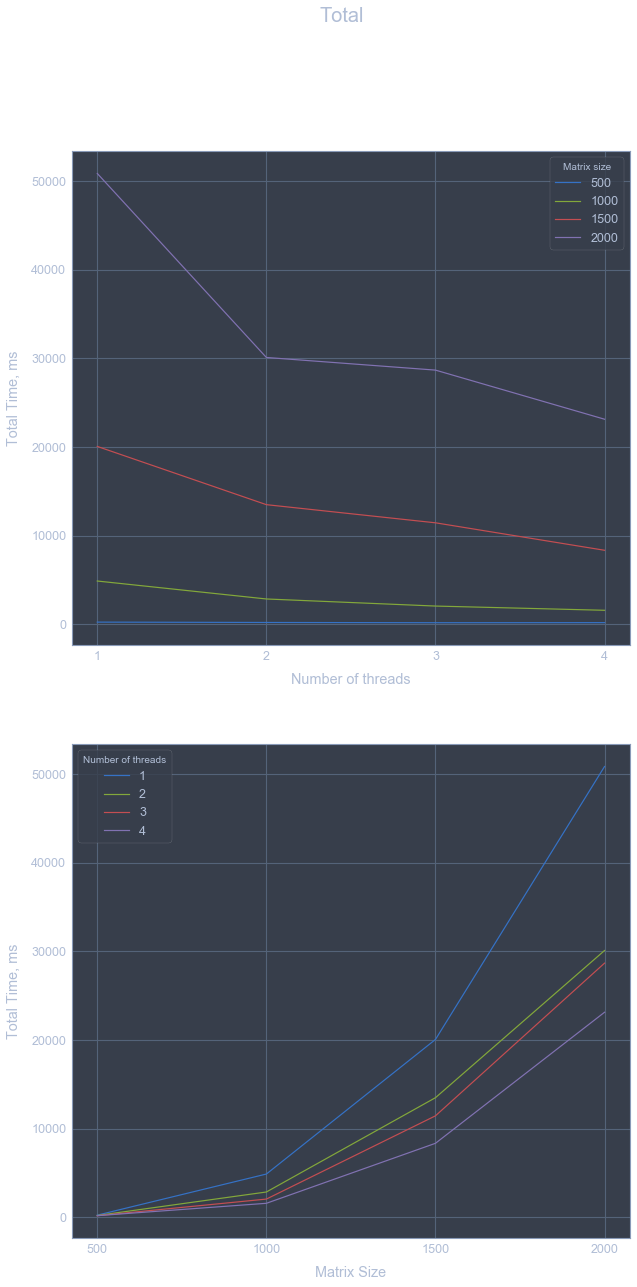

,1,2,3,4
500,266.0,227.0,198.0,206.0
1000,4899.0,2875.0,2076.0,1600.0
1500,20073.0,13507.0,11462.0,8365.0
2000,50847.0,30102.0,28677.0,23140.0


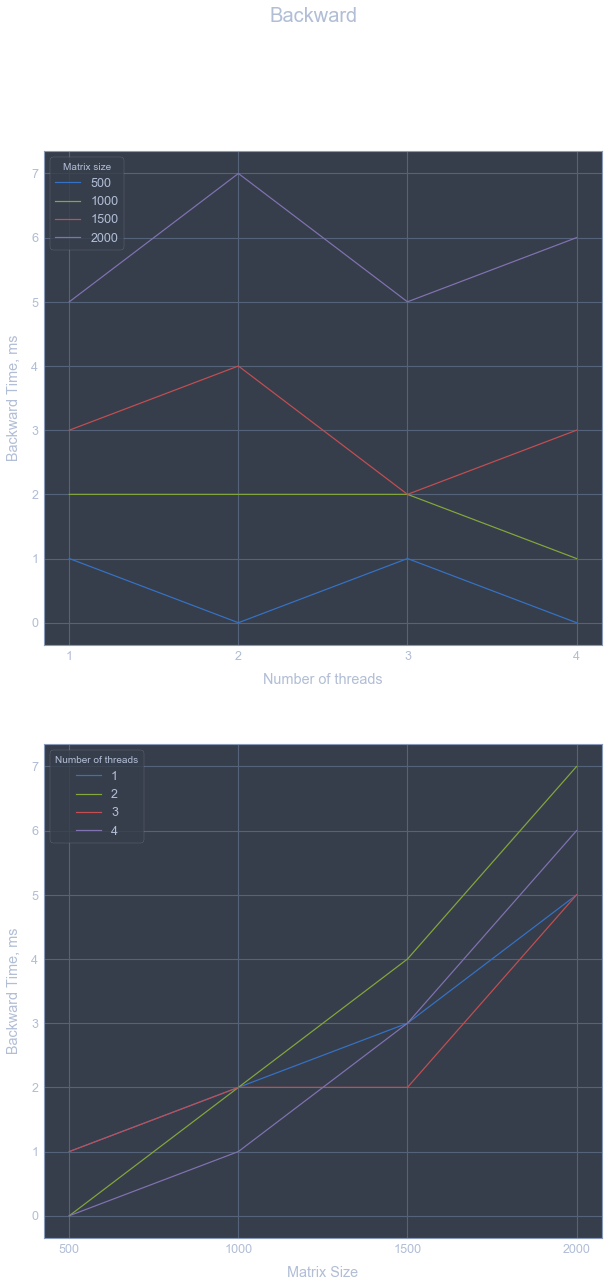

,1,2,3,4
500,1.0,0.0,1.0,0.0
1000,2.0,2.0,2.0,1.0
1500,3.0,4.0,2.0,3.0
2000,5.0,7.0,5.0,6.0


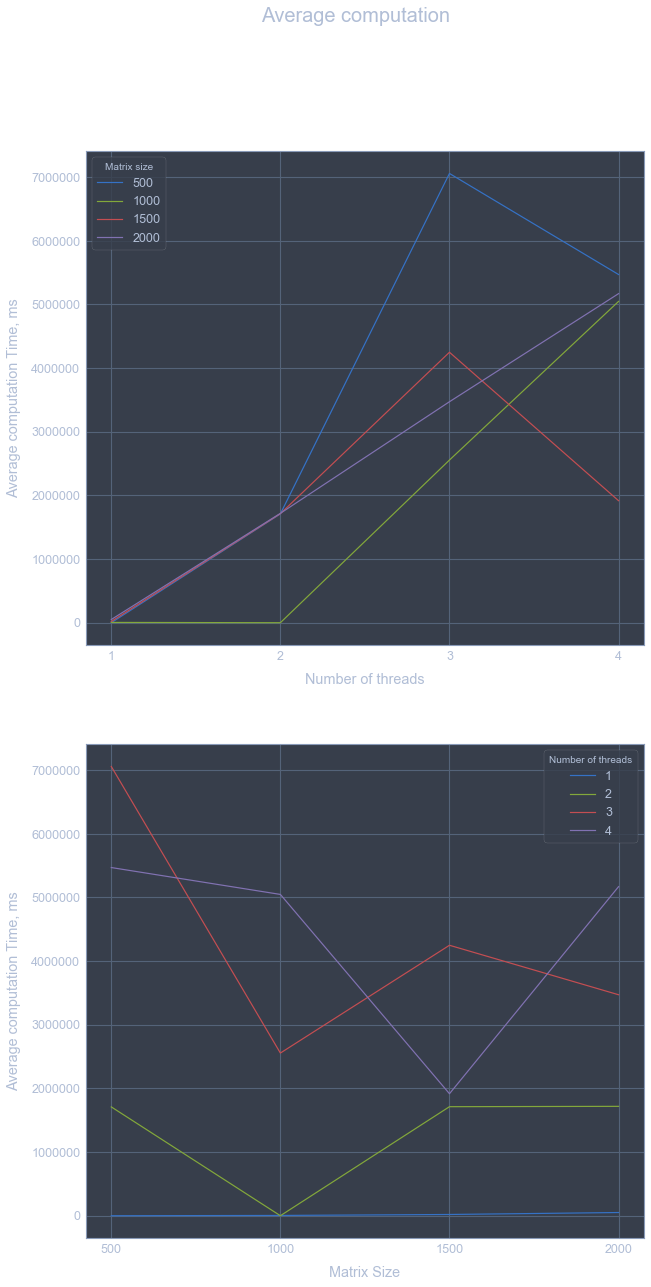

,1,2,3,4
500,260.0,1710150.5,7.058198e+06,5470492.50
1000,4864.0,477.0,2.556072e+06,5048087.75
1500,20021.0,1713441.0,4.249404e+06,1917205.50
2000,50763.0,1718880.0,3.472052e+06,5170212.50


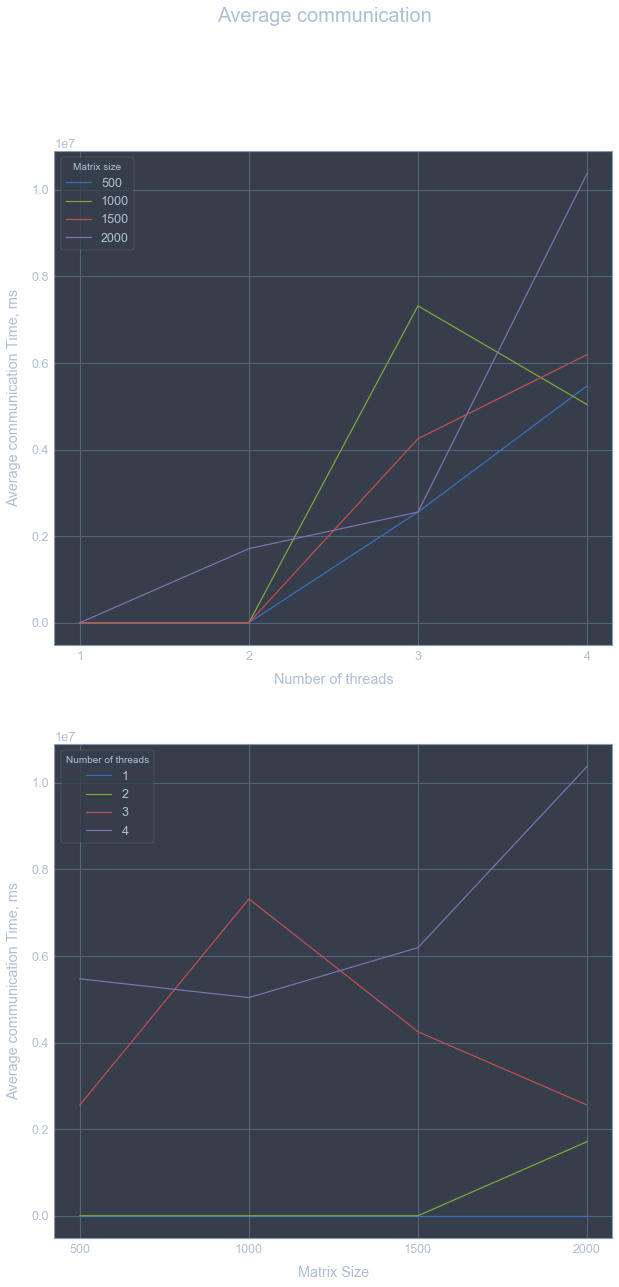

,1,2,3,4
500,0.0,11.0,2.555961e+06,5470505.00
1000,0.0,22.0,7.317043e+06,5037548.25
1500,0.0,39.5,4.248709e+06,6191463.50
2000,0.0,1710176.0,2.556034e+06,10374322.00


In [12]:
for k, s in enumerate(['Total', 'Backward', 'Average computation', 'Average communication']):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,20))
    fig.suptitle(s, fontsize=20)
    # By matrix size
    for i, n in enumerate(n_range):
        ax1.plot(t_range, vals[i,:,k])
    ax1.legend(n_range, loc='best', title='Matrix size')
    ax1.set_xlabel('Number of threads',labelpad=10)
    ax1.set_xticks(t_range)
    ax1.set_ylabel(f'{s} Time, ms',labelpad=10)

    # By number of threads
    for j, t in enumerate(t_range):
        ax2.plot(n_range, vals[:,j,k].flatten())
    ax2.legend(t_range, loc='best', title='Number of threads')
    ax2.set_xlabel('Matrix Size',labelpad=10)
    ax2.set_xticks(n_range)
    ax2.set_ylabel(f'{s} Time, ms',labelpad=10)

    plt.show()
    display(pd.DataFrame(data=vals[:,:,k], index=n_range, columns=t_range))